# Preprocessing

In [1]:
# NLTK, stands for Natural Language Toolkit, is a library for English punctuations, statistics, and NLP
# NLTK contains 100 words like I, my, me, over, postposition, suffix, but not needed/necessary for abstraction
# use NLTK to remove stopwords from dataset
import nltk
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import urllib.request
import numpy as np
import pandas as pd
import os, re
import matplotlib.pyplot as plt
import requests
import summa

from summa.summarizer import summarize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# load data from url
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
# this data has 2 columns: text(details of the news) and headlnies(summary of the news)
# abstractive summarization: use text as main and headlines as summarized version
# extractive summarization: only use text column
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
# print 15 random samples
data.sample(15)

,headlines,text
72432,"Ensure free basement parking in malls, pvt hos...",The South Delhi Municipal Corporation (SDMC) h...
76948,Jab Harry Met Sejal lowest opening grosser for...,"'Jab Harry Met Sejal', with Ã¢ÂÂ¹15.25 crore ..."
96146,US President Donald Trump is using a new iPhon...,US President Donald Trump is using a new iPhon...
85103,"160 filmmakers, artists write to I&B Minister ...",A letter addressed to the Information and Broa...
71725,Apple ends its annual music festival after 10 ...,Technology giant Apple has decided to end host...
80102,Thousands attend neo-Nazi rock concert in Germany,"More than 6,000 people attended Germany's larg..."
35833,Andhra CM Naidu compares NDA government to 'Br...,"Interacting with TDP leaders, Andhra Pradesh C..."
89499,India's disabled cricketers get contracted at ...,India's top 20 disabled players have been give...
64585,Haryana govt plans 'PGs for cattle' to boost m...,To allow people living in high-rises and urban...
46977,Pak cricketer Shahzad shares workout pic with ...,Pakistani batsman Ahmad Shahzad took to Twitte...


In [5]:
# pandas.DataFrame.nunique: count num of unique elements
# checking for num of unique vals
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# use drop_duplicates to remove any duplicates
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
# check for any null vals
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [8]:
# dropna to remove any null val rows
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## Regex

In [9]:
# dictionary for text normalization
# text normalization: process of transforming text into a single canonical form that it might not have had before
# canonical form: standard way of presenting that object as a mathematical expression
# mathematical expression: finite combination of symbols that is well-formed according to rules that depend on the context
# contraction: words or combinations of words that are shortened by dropping letters and
# replacing them by an apostrophe, and removing them contributes to text standardization
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
               "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
               "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
               "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
               "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
               "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
               "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
               "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
               "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
               "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
               "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
               "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
               "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
               "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
               "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
               "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
               "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
               "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
               "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
               "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
               "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
               "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
               "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
# stopwords: commonly used in texts, but not helpful during NLP process
# removing stopwords may improve the performance of the NLP
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# # only prreprocess sentence in text cols, but not in summary cols to have natural sentences
# def preprocess_sentence(sentence, remove_stopwords=True):
#     sentence = sentence.lower() # lowercase text
#     sentence = BeautifulSoup(sentence, "lxml").text # remove HTML tags like <br />, <a href = ...>
#     sentence = re.sub(r'\([^)]*\)', '', sentence) # remove words in parenthesis (...) Ex) my husband (and myself!) for => my husband for
#     sentence = re.sub('"','', sentence) # remove double quotes
#     sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # abbreviage/contraction normalize
#     sentence = re.sub(r"'s\b","", sentence) # remove possessive case Ex) roland's -> roland
#     sentence = re.sub("[^a-zA-Z]", " ", sentence) # anything other than Eng, change to blank
#     sentence = re.sub('[m]{2,}', 'mm', sentence) # if m is 3 or more, change to 2. Ex) ummmmmmm yeah -> umm yeah
    
#     # remove stopwords (Text)
#     if remove_stopwords:
#         tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
#     # don't remove stopwords (Summary)
#     else:
#         tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
#     return tokens

In [12]:
# # example sentences after regex
# temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
# temp_headlines = 'Great way to start (or finish) the day!!!'

# print("text: ", preprocess_sentence(temp_text))
# print("summary:", preprocess_sentence(temp_headlines, False))  # use param False to not remove stopwords

In [13]:
# # regex text column
# clean_text = []
# for s in data['text']:
#     clean_text.append(preprocess_sentence(s))

# print("Text 전처리 후 결과: ", clean_text[:5])

In [14]:
# # regex headlines column
# clean_headlines = []
# for s in data['headlines']:
#     clean_headlines.append(preprocess_sentence(s, False))

# print("Headlines 전처리 후 결과: ", clean_headlines[:5])

In [15]:
def preprocess_sentence(df:pd.DataFrame, col_name:str, remove_stopwords:bool=True) -> None:
    """
    영어 문장의 내용을 전처리하는 함수
    처리전의 내용은 스크렙을 통해 가저온 기사로 가정하고 데이터를 처리한다.
    처리과정은 아래의 순서에 따른다.
    - 텍스트 소문자화
    - 양 옆의 필요없는 whitespace, 개행문자 제거
    - \<br>, \<a href \= ...\> 등의 html 태그 제거
    - 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    - 쌍따옴표(") 제거
    - 약어 정규화(`contractions`상수 참고)
    - 소유격 제거. Ex) roland's -> roland
    - 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    - m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    - 불용어 제거/미제거

    Examples
    ----------
    >>> df = pd.DataFrame(data=[
    >>> [
    >>>     '''Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, 
    >>>     was a Sr Systems Engineer at Infosys with almost 5 years of work experience.'''
    >>>     '''Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year.'''
    >>> ],[
    >>>     '''upGrad learner switches to career in ML & Al with 90% salary hike''',
    >>>     '''Delhi techie wins free food from Swiggy for one year on CRED'''
    >>> ]
    >>> ], columns=['text', 'summary'])
    >>> preprocess_sentence(df, 'text')
    >>> print(df['text'])
    
    Parameters
    ----------
    df : DataFrame
        영어로 써있는 문장이 들어가있는 데이터프레임
    col_name : str
        전처리할 컬럼의 이름
    remove_stopwords : bool, default = True
        불용어 삭제여부

    Returns
    -------
    None

    """
    stopwords_eng_dict=set(stopwords.words('english'))
    df[col_name] = df[col_name].str.lower()
    df[col_name] = df[col_name].str.strip()
    df[col_name] = BeautifulSoup("\n".join(df[col_name].to_list()), "lxml").text.split("\n")
    df[col_name] = df[col_name].replace(r"\([^)]*\)", "", regex=True)
    df[col_name] = df[col_name].replace(r"'s\b","", regex=True)
    df[col_name] = [
                     " ".join([
                         contractions.get(w, w)
                         for w in l
                         ]) for l in df[col_name].str.split()
                    ]
    df[col_name] = df[col_name].replace("[^a-zA-Z]", " ", regex=True)
    df[col_name] = df[col_name].replace("[m]{2,}", "mm", regex=True)
    if remove_stopwords:
        df[col_name] = [
                        " ".join([
                                w for w in l
                                if (not w in stopwords_eng_dict
                                and len(w) > 1)
                            ]) for l in df[col_name].str.split()
                        ]
    else:
        df[col_name] = [
                        " ".join([
                                w for w in l
                                if len(w) > 1
                            ]) for l in df[col_name].str.split()
                        ]
    df[col_name] = df[col_name].str.strip()

In [16]:
# regex text column
preprocess_sentence(data, 'text')

print("Text 전처리 후 결과: ", data['text'][0])

Text 전처리 후 결과:  saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers


In [17]:
# regex headlines column
preprocess_sentence(data, 'headlines', False)

print("Headlines 전처리 후 결과: ", data['headlines'][0])

Headlines 전처리 후 결과:  upgrad learner switches to career in ml al with salary hike


In [18]:
# cross-check whether there are any empty samples as there might be some after regex
# change empty vals to Null if any
data.replace('', np.nan, inplace=True)

In [19]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [20]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


# Max length and encoder decoder

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.0970109800732
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.29447946319642


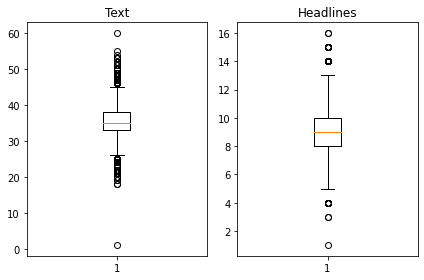

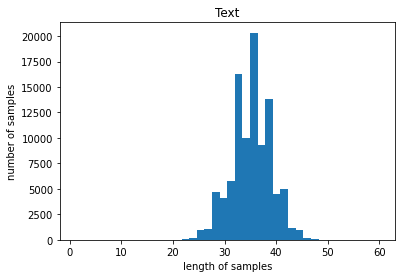

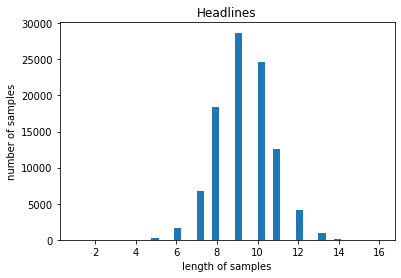

In [21]:
# choose max sample length
# best to visualize min, max, mean length of text and headlines
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
# arbitrary text max len and headlines max len
text_max_len = 50
headlines_max_len = 10

In [23]:
# function to see how many samples will be included without clipping
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [24]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8180866205774705


In [25]:
# skip sentences that are longer than chosen max length
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 80456


In [26]:
# with seq2seq training, need to add 'sos' to decoder input and 'eos' to decoder target from headlines column
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [27]:
# save in np.array format
encoder_input = np.array(data['text']) # encoder input
decoder_input = np.array(data['decoder_input']) # decoder input
decoder_target = np.array(data['decoder_target']) # decoder label

# Train test split

In [28]:
# this time split by manual coding
# create mixed int sequence with the size of encoder input
indices = np.arange(encoder_input.shape[0]) # indices = np.arange(80456)
np.random.shuffle(indices) # shuffle 80456
print(encoder_input[0])
print(encoder_input.shape[0])
print(indices)

new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history
80456
[63602  6633 34369 ... 18272 53941 42889]


In [29]:
# shuffle samples with int sequence
print('pre', encoder_input)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print()
print('post', encoder_input)

pre ['new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years'
 'pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads press release issued behalf rahat statement called allegation bizarre'
 ...
 'uff yeh first song sonakshi sinha starrer upcoming drama film noor released song composed amaal mallik vocals armaan malik lyrics manoj muntashir sonakshi seen portraying pakistani journalist writer film directed 

In [30]:
# find 20% of the length of encoder input
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 16091


In [31]:
# split data into train and test
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 64365
훈련 레이블의 개수 : 64365
테스트 데이터의 개수 : 16091
테스트 레이블의 개수 : 16091


# Tokenization

In [32]:
# Keras tokenizer will create vocabulary
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train) # create vocab from input data

In [33]:
# set threshold to see how many repeated words under the threshold take part in data 
# src_tokenizer.word_counts.items() saves words and count of words, so it's a good way to retrieve stats from it

threshold = 7
total_cnt = len(src_tokenizer.word_index) # vocab amount
rare_cnt = 0 # count if the words appear less than the set threshold
total_freq = 0 # count total words appearance from train data
rare_freq = 0 # if rare word apperance

# receive word and frequency as key value pair
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # if word count is less than the threshold
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# percentage of word count that's less than 6 counts as approx 68%
# but frequency only consists of 4%

단어 집합(vocabulary)의 크기 : 64988
등장 빈도가 6번 이하인 희귀 단어의 수: 44661
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 20327
단어 집합에서 희귀 단어의 비율: 68.721917892534
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.015866899060643


In [34]:
# remove any words with word count less than 7 from int encoding process
# now vocab reduces to 20000
# set num_words to limit the vocab
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train) # regenerate word vocab

In [35]:
# texts_to_sequences: change words to int
# since word limited to 20000, anything after won't exist

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# print samples
print(encoder_input_train[:3])

[[1878, 939, 1325, 9394, 1742, 1, 1023, 274, 2309, 18, 128, 5403, 1, 2005, 18, 799, 184, 2005, 18, 799, 3278, 6, 100, 9394, 1621, 1398, 1023], [1455, 1480, 869, 1602, 84, 172, 380, 1531, 3301, 1414, 4434, 19, 4931, 1414, 6886, 272, 496, 3676, 2378, 484, 1496, 5463, 13425, 1226, 2662, 903, 1026, 792, 17, 2029, 5339, 159, 1514, 3619, 6, 1414, 8806], [300, 16, 1635, 1060, 80, 182, 1546, 833, 3058, 1210, 22, 388, 1006, 949, 5996, 16841, 6322, 13426, 1591, 954, 149, 1210, 731, 9, 1006, 8, 20, 250, 6067, 809, 10, 276, 1546, 80]]


In [36]:
# same process goes for decoder
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [37]:
# set threshold to see how many repeated words under the threshold take part in data 
# tar_tokenizer.word_counts.items() saves words and count of words, so it's a good way to retrieve stats from it

threshold = 5
total_cnt = len(tar_tokenizer.word_index) # vocab amount
rare_cnt = 0 # count if the words appear less than the set threshold
total_freq = 0 # count total words appearance from train data
rare_freq = 0 # if rare word apperance

# receive word and frequency as key value pair
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # if word count is less than the threshold
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28298
등장 빈도가 4번 이하인 희귀 단어의 수: 17740
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10558
단어 집합에서 희귀 단어의 비율: 62.68994275213796
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.850802278455012


In [38]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 532, 498, 403, 154, 145, 9505, 6044], [1, 9, 657, 6, 4392, 6415, 13, 302, 867, 208], [1, 115, 315, 251, 911, 3, 361, 34, 358, 1217], [1, 6416, 1063, 53, 2582, 2038, 17, 1125, 3456, 6884, 8662], [1, 1996, 112, 815, 1105, 127, 251, 3163, 5, 889]]
target
decoder  [[532, 498, 403, 154, 145, 9505, 6044, 2], [9, 657, 6, 4392, 6415, 13, 302, 867, 208, 2], [115, 315, 251, 911, 3, 361, 34, 358, 1217, 2], [6416, 1063, 53, 2582, 2038, 17, 1125, 3456, 6884, 8662, 2], [1996, 112, 815, 1105, 127, 251, 3163, 5, 889, 2]]


In [39]:
# removing less frequently used words, can lead to empty samples, especially with headlines since it contains 6 words or less
# thus need to remove rows with empty(or only contain 'sostoken' / 'eostoken') samples
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 64365
훈련 레이블의 개수 : 64365
테스트 데이터의 개수 : 16091
테스트 레이블의 개수 : 16091


In [40]:
# add padding sequence
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# Model construction

In [41]:
# encoder model building
embedding_dim = 300
hidden_size = 256 # parameter to define how much capacity the layer will contain = amount of neuron / size of layer

# encoder
encoder_inputs = Input(shape=(text_max_len,))

# encoder embedding layer
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# encoder LSTM 1
encoder_lstm1 = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4))
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
# encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(enc_emb)

# encoder LSTM 2
encoder_lstm2 = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4))
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_output1)

# encoder LSTM 3
encoder_lstm3 = Bidirectional(LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm3(encoder_output2)

state_h = Concatenate()([forward_h, backward_h]) # hidden state
state_c = Concatenate()([forward_c, backward_c]) # cell state

# need to send encoder's output to decoder

# LSTM has parameter called recurrent dropout as well
# normal dropout removes layer's weight randomly to restrict overfitting

# recurrent dropout proceed with dropout every time step instead of layer = skips time step input randomly
# it has regularization effect and restricts overfitting

# using both dropout and recurrent dropout is called variational dropout

In [42]:
# decoder model building
decoder_inputs = Input(shape=(None,))

# decoder embedding layer
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# decoder LSTM
# hidden size was 256 for decoder_lstm but changed to 512 since encoder was bidirectional
decoder_lstm = LSTM(2*hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [43]:
# decoder output layer
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# model summary
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 300)      6000000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 50, 512), (N 1140736     embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 50, 512), (N 1574912     bidirectional[0][0]              
______________________________________________________________________________________________

In [44]:
# make attention layer and fix decoder output layer

# attention layer
attn_layer = AdditiveAttention(name='attention_layer')

# send encoder and decoder's every time step's hidden state to attention layer and return result
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# connect attention output with decoder's hidden state
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# decoder output layer
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# model summary
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 300)      6000000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 50, 512), (N 1140736     embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 50, 512), (N 1574912     bidirectional[0][0]              
____________________________________________________________________________________________

In [45]:
# compile and train model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
252/252 [==============================] - 362s 1s/step - loss: 6.2691 - val_loss: 5.7863
Epoch 2/50
252/252 [==============================] - 336s 1s/step - loss: 5.5668 - val_loss: 5.2427
Epoch 3/50
252/252 [==============================] - 335s 1s/step - loss: 5.0368 - val_loss: 4.8932
Epoch 4/50
252/252 [==============================] - 334s 1s/step - loss: 4.6532 - val_loss: 4.6487
Epoch 5/50
252/252 [==============================] - 333s 1s/step - loss: 4.3439 - val_loss: 4.4864
Epoch 6/50
252/252 [==============================] - 333s 1s/step - loss: 4.0819 - val_loss: 4.3734
Epoch 7/50
252/252 [==============================] - 331s 1s/step - loss: 3.8537 - val_loss: 4.2869
Epoch 8/50
252/252 [==============================] - 331s 1s/step - loss: 3.6476 - val_loss: 4.2418
Epoch 9/50
252/252 [==============================] - 331s 1s/step - loss: 3.4598 - val_loss: 4.1938
Epoch 10/50
252/252 [==============================] - 331s 1s/step - loss: 3.2934 - val_lo

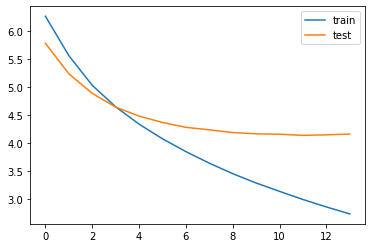

In [46]:
# visualize loss of train and test
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [47]:
# during test, actual words are needed, so creating 3 dict
src_index_to_word = src_tokenizer.index_word # text vocab int -> word
tar_word_to_index = tar_tokenizer.word_index # headlines vocab word -> int
tar_index_to_word = tar_tokenizer.index_word # headlines vocab int -> word

In [48]:
# seq2seq has two diff ways of model building for training and inferencing

# during training, decoder input recieves one whole sentence of answer and compare with decoder output at once
# so only 1 mode is needed

# inference stage(without label words/sentences) decoder needs to repeat as much as sentence length (until eos is reached)
# thus separate model is needed and encoder model is split with decoder model

# encoder model building
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# tensor with previous states
decoder_state_input_h = Input(shape=(hidden_size*2,))
decoder_state_input_c = Input(shape=(hidden_size*2,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# in order to predict next word of a sentence, initial state will be the last time step state, which is configured in decode_sequence()
# do not throw away hidden state: state_h and cell state: state_c unlike training stage
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [49]:
# attention layer
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size*2))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# decoder output
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [50]:
# function to finalize word sequence during inference

def decode_sequence(input_seq):
    # receive encoder state from input
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # create <SOS> token
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    # run while loop until stop_condition becomes True
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  stop while loop when reached <eos> or goes over max length
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # update target sequence with length 1
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # update state
        e_h, e_c = h, c

    return decoded_sentence

In [51]:
print(decoder_model)

In [52]:
# easier to change from int seq to word seq to check the outcome
# do not include padding 0 from text int sequence
# do not include 0, sos token, and eos token from headlines

# function to change text int seq to word seq
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# headlines int seq to word seq
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [53]:
# compare result
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

# 2. 빔 서치(beam search)
# 3. 사전 훈련된 워드 임베딩(pre-trained word embedding),
# 4. 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재합니다.

원문 : number students scored marks year cbse class board exams rose last year girls boys year notably government schools saw pass percentage year results beating private schools whose pass percentage 
실제 요약 : students scoring above in cbse class rose in 
예측 요약 :  students in haryana class board exams


원문 : uber ola drivers go strike across cities including mumbai gurugram nation capital delhi march drivers plan protest front ola uber offices demanding companies ensure business worth lakh per month also seek fares decided according vehicles 
실제 요약 : ola uber to go on strike on march 
예측 요약 :  uber to start uber drivers to go on strike


원문 : hours detected april asteroid swept past earth speed kmph half distance moon astronomers revealed asteroid ge estimated diameter metres made closest approach km whereas earth average distance moon km 
실제 요약 : asteroid flies by earth closer than moon hrs after detection 
예측 요약 :  asteroid on earth may be named by asteroid nasa


원문 : white house quie

예측 요약 :  interpol raids zakir naik in nigeria probe


원문 : year old man jumped bandra worli sea link mumbai thursday commit suicide admitted hospital police said taxi driver reported incident police control room following team police personnel rushed spot police identified man yet regain consciousness 
실제 요약 : man jumps off bandra sea link survives 
예측 요약 :  man killed as mumbai air force he jumps her


원문 : india played icc champions trophy previous seven editions tournament finishing joint winners sri lanka india edition without dropping single match edition first major icc tournament virat kohli captain indian team 
실제 요약 : how has india performance been in icc champions trophy 
예측 요약 :  india beat pakistan to win champions trophy


원문 : students indian institute management calcutta proposed plan launch virtual grocery stores kolkata metro stations partnering commerce majors like flipkart amazon idea involves installing wall length billboards displaying product images along qr code 

예측 요약 :  uber to end self driving cars in us


원문 : delhi court monday framed charges army major nikhil rai handa murder colleague wife dwivedi chargesheet filed police reveals night incident handa watched various videos youtube kill someone handa allegedly killed dwivedi refused marry 
실제 요약 : charges framed against major in murder case 
예측 요약 :  delhi hc orders sit to sit blast accused


원문 : cambodia officially banned selling exporting human breast milk us reports exposed women turning controversial trade boost incomes country earlier unicef condemned trade calling notably us company exporting milk women labs cambodia two years 
실제 요약 : cambodia bans breast milk trade exports to the us 
예측 요약 :  sweden bans sale of its first in


원문 : year old whale continuously carrying dead calf canadian coast since died two weeks ago shortly birth scientists tracking mother expressed concerns well falling behind group calf first born group years left 
실제 요약 : mother of dead whale still carrying i

# Extractive Summarization

In [54]:
# load data
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
text = data['text']
text

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object

In [55]:
# summarize(data['text'].iloc[19], ratio=0.5)

In [56]:
# pandas.Series.str.cat
# text = text[50:100].str.cat(sep='\n')

In [57]:
# check data
print(text)

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object


In [58]:
# summarize with ratio of 0.4
for i in range(50,100):
    print(summarize(text[i], ratio=0.5))

Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).
Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018.

Further, its OnePlus 6 emerged as the highest selling premium smartphone of 2018 followed by OnePlus 6T.
Filmmaker Pooja Bhatt, while talking about the presentation of women in her films, said, "I can never look at a female body, even if it's naked, in a vulgar manner." "Our audience can say...the women in my films are bold or sensual, but never ever vulgar," she added.
Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said the film's co-director Kangana Ranaut made false promises to the cast.
The high-powered committee led by PM Narendra Modi to select the next CBI Director will meet again on February 1, Congress leader Mallikarjun Kharge has said.
Nevada State Athletic Commi

In [59]:
# summarize with ratio of 0.4 and put it to a list
for i in range(50,100):
    print(summarize(text[i], ratio=0.5, split=True))

['Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢Â\x82Â¹31,000 crore by Dewan Housing Finance (DHFL).']
["Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018."]
[]
['Further, its OnePlus 6 emerged as the highest selling premium smartphone of 2018 followed by OnePlus 6T.']
['Filmmaker Pooja Bhatt, while talking about the presentation of women in her films, said, "I can never look at a female body, even if it\'s naked, in a vulgar manner." "Our audience can say...the women in my films are bold or sensual, but never ever vulgar," she added.']
["Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said the film's co-director Kangana Ranaut made false promises to the cast."]
['The high-powered committee led by PM Narendra Modi to select the next CBI Director will meet again on February 1, Congress leader Mallikarjun Kharge has said.

In [60]:
# summarize by words
for i in range(50,100):
    print(summarize(text[i], words=15))

Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).
Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018.

Further, its OnePlus 6 emerged as the highest selling premium smartphone of 2018 followed by OnePlus 6T.

Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said the film's co-director Kangana Ranaut made false promises to the cast.
The high-powered committee led by PM Narendra Modi to select the next CBI Director will meet again on February 1, Congress leader Mallikarjun Kharge has said.


Sreesanth further said the bookie tried dragging him into spot-fixing but he didn't fall for it.
The Finance Ministry on Wednesday said the government will present an Interim Budget on February 1.
US President Donald Trump on Wednesday called his country's top intelligence chiefs "naive" and

# 회고

1회차
- regex를 이용한 전처리 부분에서 너무 오랜 시간이 걸리기에 다른 방식으로 구현해 보기로 하였다.
    - 한용님이 더 빠른 전처리 방법을 알려주셔서 사용해보았다.
    - 전에는 10분과 5분이 걸리는 전처리 과정이 둘 다 1분안에 끝나는 쾌거를 이루었다.

2회차
- 모델훈련후 결과를 출력해보니 전혀 요약과 비슷한 결과를 내놓지 못했다.
- summarize는 40% 정도 비율을 정해줘야 결과가 나오기 시작했다.
    - 그보다 적은 숫자를 정하면 빈 칸을 출력했다.
    - 50% 정도로 하거나 단어수 지정을 15정도로 하면 대부분 추출 요약 잘 되어 나타나는 것을 볼수가 있었다.

3회차
- 요약 결과가 별로 좋지가 않아서 LSTM대신 BiLSTM을 encoder에만 적용시켜 보기로 했다.
    - https://github.com/tensorflow/nmt 글에서 hyperparameter section에서 bahdanau-style attention layer (additive attention)를 사용한다면 encoder에만 LSTM 대신 BiLSTM을 사용하면 모델 학습이 더 잘 된다는 말을 하여 적용해 보았다.
    - decoder 설계 부분에 ValueError: An `initial_state` was passed that is not compatible with `cell.state_size`. Received `state_spec`=ListWrapper([InputSpec(shape=(None, 512), ndim=2), InputSpec(shape=(None, 512), ndim=2)]); however `cell.state_size` is [256, 256] 에러가 났다
    - 인터넷에서 찾아봐서 decoder LSTM에 hidden size를 변경하면 가능할 것 같다는 생각이 들어 바꿔서 에러를 해결하고 전체 코드를 돌려보았다.
    - 다시 attention layer에서 같은 에러가 났다
    - outputs 설정이 잘못되어서 차원수를 잘못 계산되는 에러여서 곧 해결할 수 있었다.
- 에러들을 다 해결한 후 다시 한번 모델 재학습 및 출력결과를 확인하기로 했다.

4회차
- Beam search, pre-trained word embedding 적용?